<a href="https://colab.research.google.com/github/Ekpenyong-Esu/Deep-RL-Exercise/blob/main/continous_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:

#!pip3 install pyvirtualdisplay
#!pip install gym[classic_control]

In [19]:
#!apt update && apt install xvfb
#!pip install gym-notebook-wrapper
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [20]:
from IPython import display

In [21]:
%matplotlib notebook

import time  # slow the game down a little bit
#from pyglet.window import key  # for manual playing

import gym
import numpy as np  # used for all kinds of matrix / vector operations
import matplotlib.pyplot as plt  # for plotting

In [22]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9


NUM_BINS = 10

In [23]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [24]:
# Exploration vs. Exploitation parameters
#epsilon = 1.0                 # Exploration rate
#max_epsilon = 1.0             # Exploration probability at start
#min_epsilon = 0.01            # Minimum exploration probability 
#decay_rate = 0.001             # Exponential decay rate for exploration prob

In [25]:
env = gym.make('CartPole-v1') # We want to solve the CartPole task

Let us take a look at the possible actions.
You can find them here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
As we can see, there are 4 observations:
* Cart Position (-4.8 to 4.8)
* Cart Velocity $(-\infty \text{ to } \infty)$
* Pole Angle (-0.418 to 0.418) rad or (-24 to 24) degrees
* Pole Angular Velocity $(-\infty \text{ to } \infty)$

and two actions:
* 0 - Move to the left
* 1 - Move to the right

The next cell contains code to play the game manually - Feel free to try it out by using the left and right arrow key

In [26]:
# Digitization

def create_bins(num_bins_per_action=10):
  bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_action)  # bins for the cart position
  bins_cart_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the cart velocity
  bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_action)  # bins for the pole angle
  bins_pole_angular_velocity = np.linspace(-5, 5, num_bins_per_action)  # bins for the pole angular velocity
  bins = np.array([bins_cart_position, bins_cart_velocity, bins_pole_angle, bins_pole_angular_velocity])  # merge them
  return bins

In [27]:
# digitization continues 
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [28]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(10, 10, 10, 10, 2)


In [29]:
#Epsilon greedy function 
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:

        action = np.argmax(q_table[discrete_state]) #This take all the four eleme
                                                    #nts and take The index of the 
                                                    #largest element 

    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = np.random.randint(0, env.action_space.n)

    return action

In [30]:
#Belman equation
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [31]:

BINS = create_bins(NUM_BINS)  # Create the bins used for the rest of the notebook

In [32]:
#We are going use a burn in linear reduction of epsilon

BURN_IN = 1
epsilon = 1

EPSILON_END= 10000
EPSILON_REDUCE = 0.0001



def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon-= EPSILON_REDUCE
    return epsilon

In [33]:
# We create our custom reward

def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

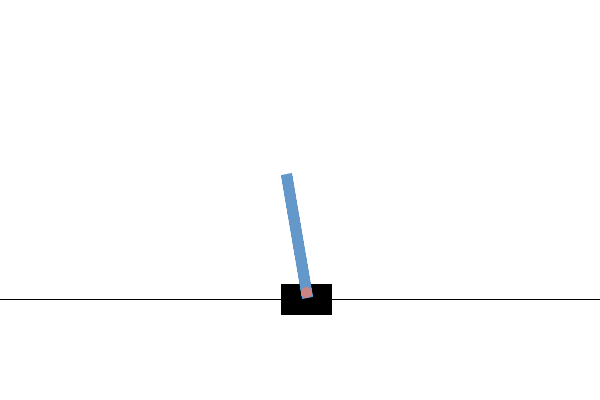

In [ ]:




for epoch in range(EPOCHS):
    
    ## Continuous State --> Discrete State
    
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    
    done = False  # to stop current run when cartpole falls down   
    points = 0  # store result
    
    
    
    
    
    while not done:  # Perform current run as long as done is False (as long as the cartpole is up)
        
       
        env.render()
        display.clear_output(wait=True)
        frame = env.render(mode='rgb_array')
        cv2_imshow(frame)
        cv2.waitKey(1)
        
       

        print(f"EPOCH is {epoch}: ")

        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection 
        next_state, reward, done, info = env.step(action)  # perform action and get next state
        reward = fail(done, points, reward)  # Check if reward or fail state


        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins

        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        

        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table

        discretized_state = next_state_discretized  # Update the old state
        points += 1

    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    
    
env.close()


In [ ]:
observation = env.reset()
rewards = 0
for _ in range(1000):
    env.render()
    discrete_state = discretize_observation(observation, BINS)  # get bins
    action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
    observation, reward, done, info = env.step(action) # Finally perform the action
    rewards+=1
    if done:
        print(f"You got {rewards} points!")
        break
env.close()
